**ML PROBLEM 5.1**

In [110]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
import torch
from keras import *

In [4]:
X_train = np.load(os.path.abspath('Xtrain_Classification1.npy'))
y_train = np.load(os.path.abspath('ytrain_Classification1.npy'))
X_test  = np.load(os.path.abspath('Xtest_Classification1.npy'))

prof da cadeira diz pa usar transfer learning


podemos só usar classificadores do sklearn tipo mlpclassifier, logistic regression, naive bayes, svm

balanced accuracy: (sensitivity + setificity)/2
sensitivity= True positive/(true positvity + false negativity)
setificity = (true negative)/(true neg + false positive)


Use pytorch neural network - harder but most usefull for harder problems (other options are jax and keras)
output layer - 2 neurons is a classification problem - use softmax (if it was 1 neuron it would be regression)



**Neural Network**


In [32]:
def balance_augmentation(x, y):
   
    
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])
    
    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:           
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment
    
    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break
    
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y, x_augmented, batch_x


In [33]:
balanced_x, balanced_y, x_augmented = balance_augmentation(X_train,y_train) #dados balanceados (igual entre classes) com augmentation - mesmo nr de melanomas que inicial

In [37]:
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data 
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data
    
  
    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500): 
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break
            
    
    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug,  x_augmented, batch_x


In [38]:
augmented_x_train, augmented_y_train, x_augmented, batch_x = data_augmentation(X_train,y_train, 2) #dados nao balanceados mas aumentados - 2x mais dados
#a fracao de melanoma continua a ser 85% de todos os samples


Epoch 1/30
80/80 [==============================] - 10s 105ms/step - loss: 1.3422 - precision_5: 0.7947 - recall_5: 0.8348 - val_loss: 1.2973 - val_precision_5: 0.2313 - val_recall_5: 0.4416
Epoch 2/30
80/80 [==============================] - 9s 107ms/step - loss: 0.7661 - precision_5: 0.8706 - recall_5: 0.8556 - val_loss: 1.3775 - val_precision_5: 0.1519 - val_recall_5: 0.9351
Epoch 3/30
80/80 [==============================] - 10s 126ms/step - loss: 0.5120 - precision_5: 0.8949 - recall_5: 0.8603 - val_loss: 1.1433 - val_precision_5: 0.1616 - val_recall_5: 0.8961
Epoch 4/30
80/80 [==============================] - 11s 139ms/step - loss: 0.4001 - precision_5: 0.9028 - recall_5: 0.8633 - val_loss: 0.6504 - val_precision_5: 0.3204 - val_recall_5: 0.7532
Epoch 5/30
80/80 [==============================] - 11s 138ms/step - loss: 0.3363 - precision_5: 0.9131 - recall_5: 0.8669 - val_loss: 0.6105 - val_precision_5: 0.3178 - val_recall_5: 0.5325
Epoch 6/30
80/80 [============================

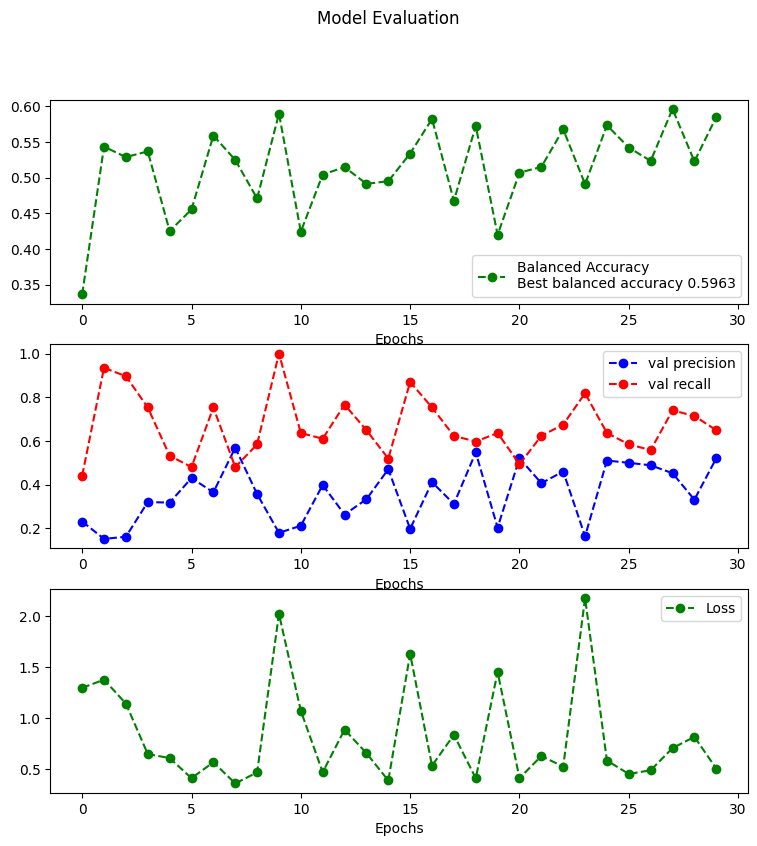

In [29]:
#run all functions before this

#create and run model with image augmentation balanced data
model_balanced, model_history_balanced = neural_defandTrain("adam", "binary_crossentropy" ,30,128,4, balanced_x, balanced_y, False)


For image augmentation balanced data
90 epochs 128batch: bba=0.6137, loss on 50 , ba converge on 50, 4.34min , adam, binarycrossentropy, balancedx,y thru augmentation
90 epochs 32 batch: bba=0.5391, loss on 90, ba 20 mas não converge bem, 6.02min, adam, binarycrossentropy, balancedx,y thru augmentation
130epochs 128batch: bba=0.0.5762, loss on 50 , ba converge on 50, 6.23min , adam, binarycrossentropy, balancedx,y thru augmentation

Conclusion: best is 128Batch and 60 epochs should be enought




Epoch 1/30
42/42 [==============================] - 6s 107ms/step - loss: 1.6570 - precision_18: 0.6564 - recall_18: 0.6564 - specificity_feitoa_mao: 0.9149 - sensitivity_feitoa_mao: 0.2353 - balanced_accuracy_feitoa_mao: 0.5751 - val_loss: 1.4633 - val_precision_18: 0.8594 - val_recall_18: 0.8594 - val_specificity_feitoa_mao: 0.8604 - val_sensitivity_feitoa_mao: 0.1672 - val_balanced_accuracy_feitoa_mao: 0.5138
Epoch 2/30
42/42 [==============================] - 4s 99ms/step - loss: 1.2954 - precision_18: 0.6546 - recall_18: 0.6546 - specificity_feitoa_mao: 0.9252 - sensitivity_feitoa_mao: 0.2632 - balanced_accuracy_feitoa_mao: 0.5942 - val_loss: 1.1311 - val_precision_18: 0.8520 - val_recall_18: 0.8520 - val_specificity_feitoa_mao: 0.8618 - val_sensitivity_feitoa_mao: 0.1776 - val_balanced_accuracy_feitoa_mao: 0.5197
Epoch 3/30
42/42 [==============================] - 4s 101ms/step - loss: 1.0527 - precision_18: 0.6500 - recall_18: 0.6500 - specificity_feitoa_mao: 0.9310 - sensitivit

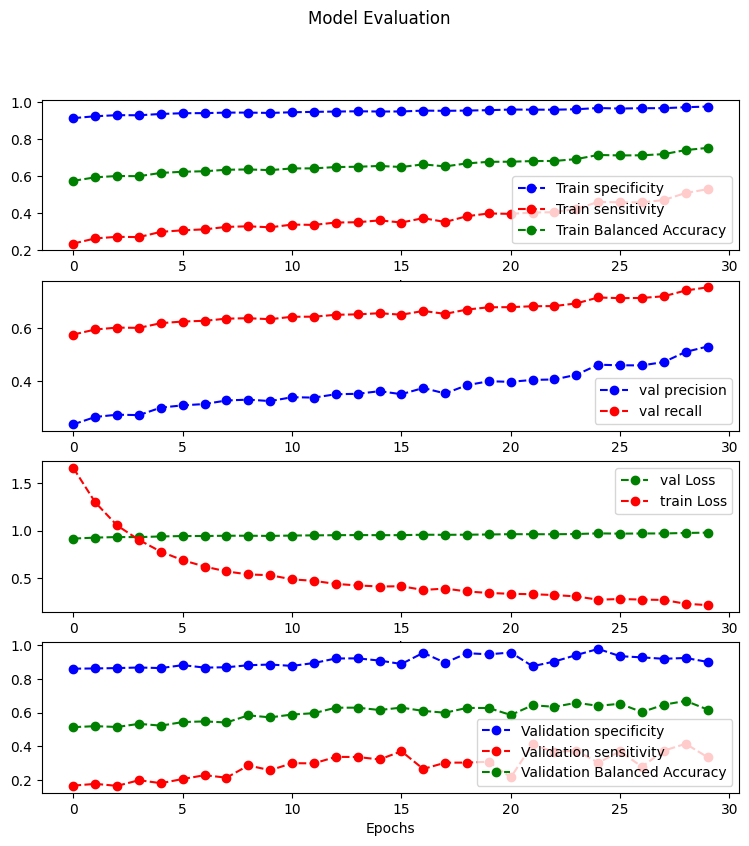

In [152]:
#create and run model without image augmentation balanced data, with class weight balance

model_weighted, model_history_weighted = neural_defandTrain("adam", "categorical_crossentropy",30,128,4, X_train, y_train, True)

90 epochs 128batch: bba=0.611, loss on 70 , ba converge on 80 - bad converge, 4.26min , adam, binarycrossentropy, balanced thru weights no augmentation
130epochs 128batch: bba=not valid 0.62, loss on 70 , ba converge on 90 para 0.52 , 6.36min , adam, binarycrossentropy, balanced thru weights no augmentation

80epochs should be enought

For image augmentation data, with class weight balance
4.20min a 90 128
6.36min a 90 32 - worst results and more time

Conclusion: use bigger batch size once again

In [91]:
#create and run model with image augmentation data, with class weight balance
model_weighted_augmented, model_history_weighted_augmented = neural_defandTrain("adam", "binary_crossentropy" ,130,128,4, augmented_x_train, augmented_y_train, True)

Epoch 1/130


NotImplementedError: in user code:

    File "c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\alexa\AppData\Local\Temp\ipykernel_18552\3852744760.py", line 9, in specificity  *
        fp = np.sum(neg_y_true * y_pred)
    File "c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py", line 2313, in sum  **
        return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
    File "c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py", line 88, in _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (mul_3:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


for image augmentation data, with class weight balance
130epochs 128batch: bba=0.6074, loss on 120 , ba converge on 120 - 0.47 , 6.42min , adam, binarycrossentropy, image augmentation data, with class weight balance


Resumo para decidir qual das 3 opções é melhor:

For image augmentation balanced data
    130epochs 128batch: bba=0.0.5762, loss on 50 , ba converge on 50, 6.23min , adam, binarycrossentropy, balancedx,y thru augmentation
for no augmentation and balanced thru weights
    130epochs 128batch: bba=not valid 0.62, loss on 70 , ba converge on 90 para 0.52 , 6.36min , adam, binarycrossentropy, balanced thru weights no augmentation
for image augmentation data, with class weight balance
    130epochs 128batch: bba=0.6074, loss on 120 , ba converge on 120 - 0.47 , 6.42min , adam, binarycrossentropy, image augmentation data, with class weight balance

Resultados mt semelhantes - talvez o melhor seja o só com pesos, sem augmentação

perguntas po prof:  acho que deviamos usar weighted validation? - não
                    normalizar os pixeis /255 - estabilidade nos gradientes
                    
                    usar regularização 

olhar pa imagens e fazer data auhmentation proporcional a estas diferenças


falta:  mudar nr de layers densar e convolucionais
        mudar optimizador
        mudar loss
        meter validation set a mudar c o tempo - mudar no fit do model e meter split
        

In [150]:
from keras import backend as k
def onehot(y_onehot):
    y = y_onehot[:,1]
    return y

def specificity_feitoa_mao(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = k.sum(neg_y_true * y_pred)
    tn = k.sum(neg_y_true * neg_y_pred)
    return tn / (tn + fp)

def sensitivity_feitoa_mao(y_pred_onehot, y_true_onehot):
    y_pred, y_true = onehot(y_pred_onehot), onehot(y_true_onehot)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fn = k.sum(neg_y_pred*y_true)
    tp = k.sum(y_true*y_pred)
    return tp / (tp + fn)

def balanced_accuracy_feitoa_mao(y_pred, y_true):  
    specificity_val = specificity(y_pred, y_true)
    sensitivity_val = sensitivity(y_pred, y_true)
    balanced_auc = (specificity_val + sensitivity_val)/2
    return balanced_auc


In [67]:
from sklearn.utils import class_weight
def weighted_balance(y_Data):
    class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes = np.unique(y_Data) ,y=np.reshape(y_Data, (y_Data.shape[0],)))
    return dict(enumerate(class_weights))


In [142]:

def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch, nrdesnelayers, x_all, y_all,classweight_bool):

    #X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all) - without model.fit(validation split)
    X_train_sample, y_train_sample = x_y_preprocessing(x_all, y_all)

    model = model_def(optimizer_string, loss_string, nrdesnelayers)

    if classweight_bool:
        class_weights=weighted_balance(y_all) #calcular pesos de cada classe
    else:
        class_weights =None

    model_history = model.fit(
        X_train_sample,
        y_train_sample,
        batch_size=batch,
        epochs=epoch_nr,
        #validation_data=(X_validation, y_validation), We pass some validation for monitoring validation loss and metrics at the end of each epoch
        validation_split=0.15,
        class_weight = class_weights)

    best_balancedAccuracy = plot_neuralmodel(model_history)
    save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy, nrdesnelayers)
    return model, model_history


In [143]:
### Neural Network
def model_def(optimizer_string, loss_string, nrdesnelayers):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3)))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    
    #model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model_img.add(layers.BatchNormalization())
    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    #we do not need to use a maxpooling layer after each convolution layer, but it helps reducing computacional load
        #for simple image convolution 2-4 conv layers should be enougth. The number of filters in 
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))                        #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns
    #dense layers
    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(64, activation='relu'))
    model_img.add(layers.Dropout(.5))
    for i in range(nrdesnelayers-2):
        model_img.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
    model_img.add(layers.Dense(2, activation='softmax'))
    

    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[keras.metrics.Precision(),keras.metrics.Recall(), specificity_feitoa_mao, sensitivity_feitoa_mao ,balanced_accuracy_feitoa_mao ]
        )

    return model_img



In [144]:

def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy, nrdesnelayers ):
    
    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  layers_{nrdesnelayers}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  layers__{nrdesnelayers}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)
   

In [149]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(9,9))
    fig.suptitle('Model Evaluation')

    best_bacc =round(max(dtf.iloc[:,11]),4)
   
    ax1.plot(dtf.iloc[:,3],'bo--',label='Train specificity')
    ax1.plot(dtf.iloc[:,4],'ro--',label='Train sensitivity')
    ax1.plot(dtf.iloc[:,5],'go--',label=f'Train Balanced Accuracy')
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,4],'bo--',label='val precision')
    ax2.plot(dtf.iloc[:,5],'ro--',label='val recall')
    ax2.legend()
    ax2.set_xlabel('Epochs')

    ax3.plot(dtf.iloc[:,3],'go--',label=f'val Loss')
    ax3.plot(dtf.iloc[:,0],'ro--',label=f'train Loss')
    ax3.legend()
    ax3.set_xlabel('Epochs')

    ax4.plot(dtf.iloc[:,9],'bo--',label='Validation specificity')
    ax4.plot(dtf.iloc[:,10],'ro--',label='Validation sensitivity')
    ax4.plot(dtf.iloc[:,11],'go--',label=f'Validation Balanced Accuracy')

    ax4.legend()
    ax4.set_xlabel('Epochs')

    plt.show()
    return best_bacc


In [63]:
def x_y_preprocessing(x,y):
    X_train_img = np.reshape(x,(x.shape[0],28,28,3)).copy()
    X_train_normalizado= X_train_img/255
    #usar no caso de não usarmos o model.fit(validatio split)
    #X_val, X_train_sample = X_train_normalizado[:500].copy(), X_train_normalizado[500:].copy()
    #y_val, y_train_sample = y[:500].copy(), y[500:].copy()
    #return X_train_sample, y_train_2labels, X_val, y_val_2labels
    
    #only used if softmax is in use
    y_train_2labels = keras.utils.to_categorical(y, num_classes=2)
    #y_val_2labels = keras.utils.to_categorical(y_val, num_classes=2)
    
    return  X_train_normalizado, y_train_2labels
    



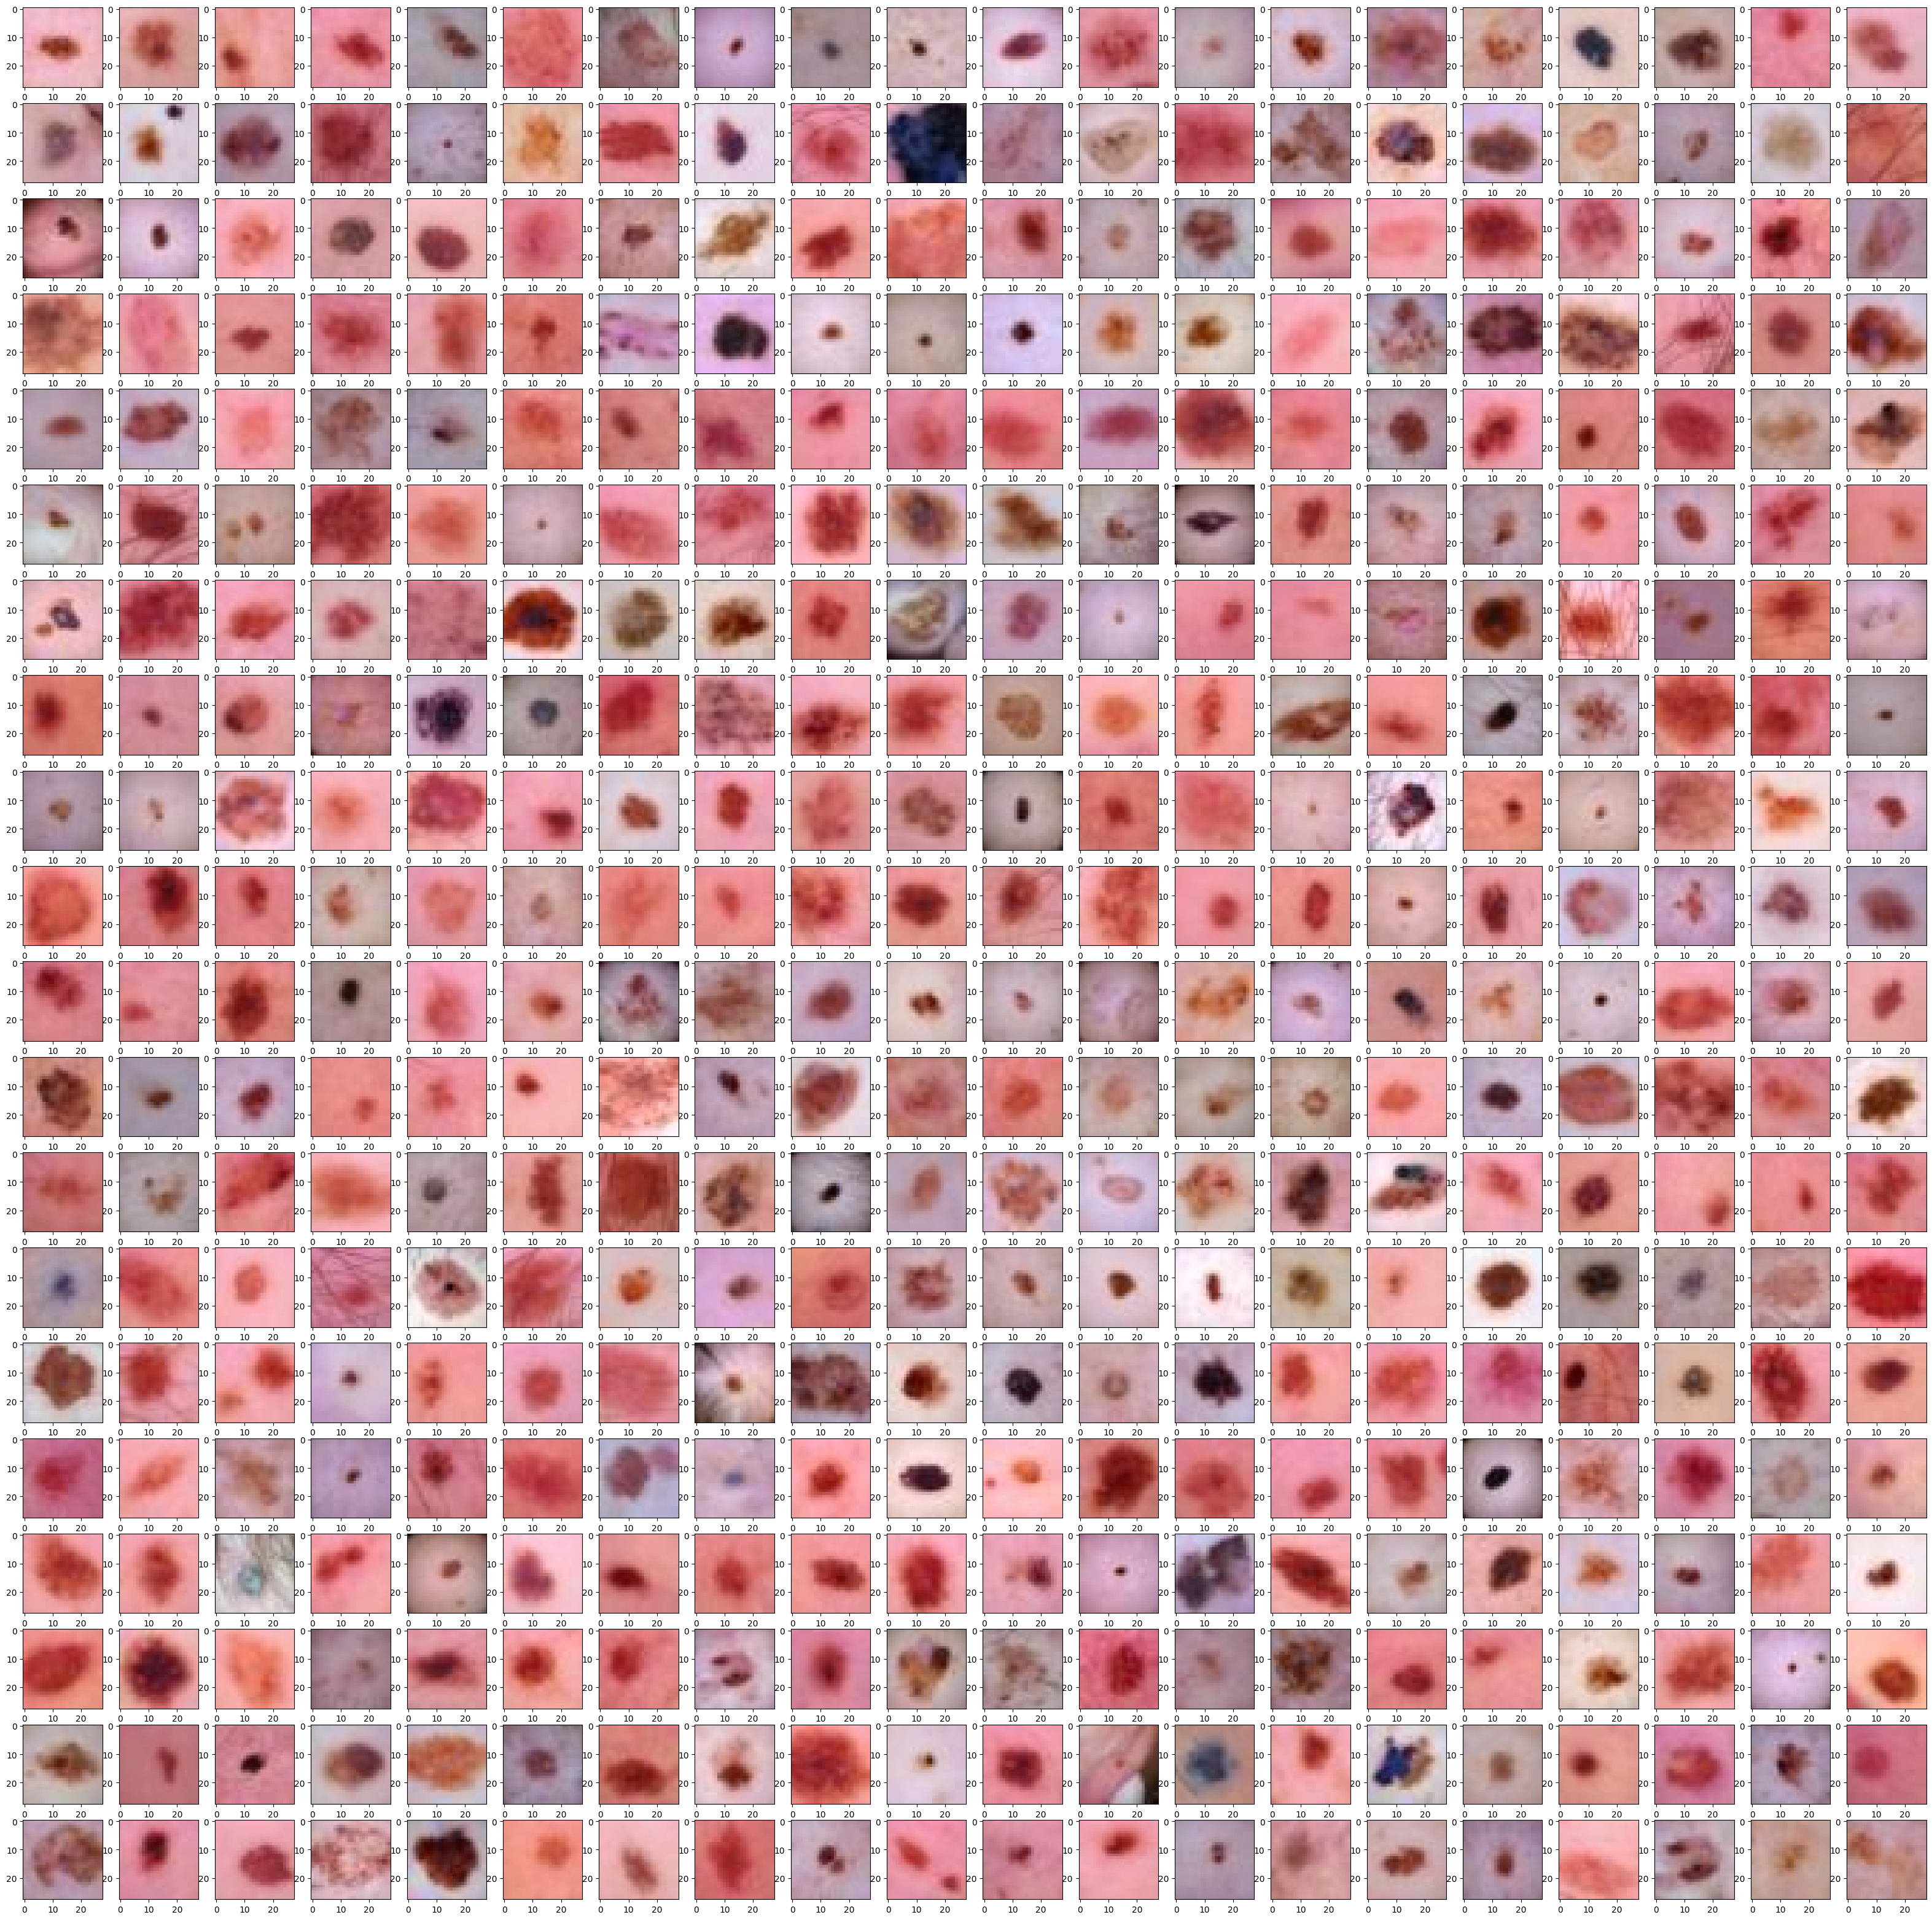

In [31]:
import numpy as np

novo = np.reshape(X_train,(6254,28,28,3))
#print(novo)
from PIL import Image
fig = plt.figure(figsize=(40, 40))
#img = Image.fromarray(novo[0], 'RGB')
#img.show()

columns = 20
rows = 20
for i in range(1,columns*rows+1):
    img = Image.fromarray(novo[i], 'RGB')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

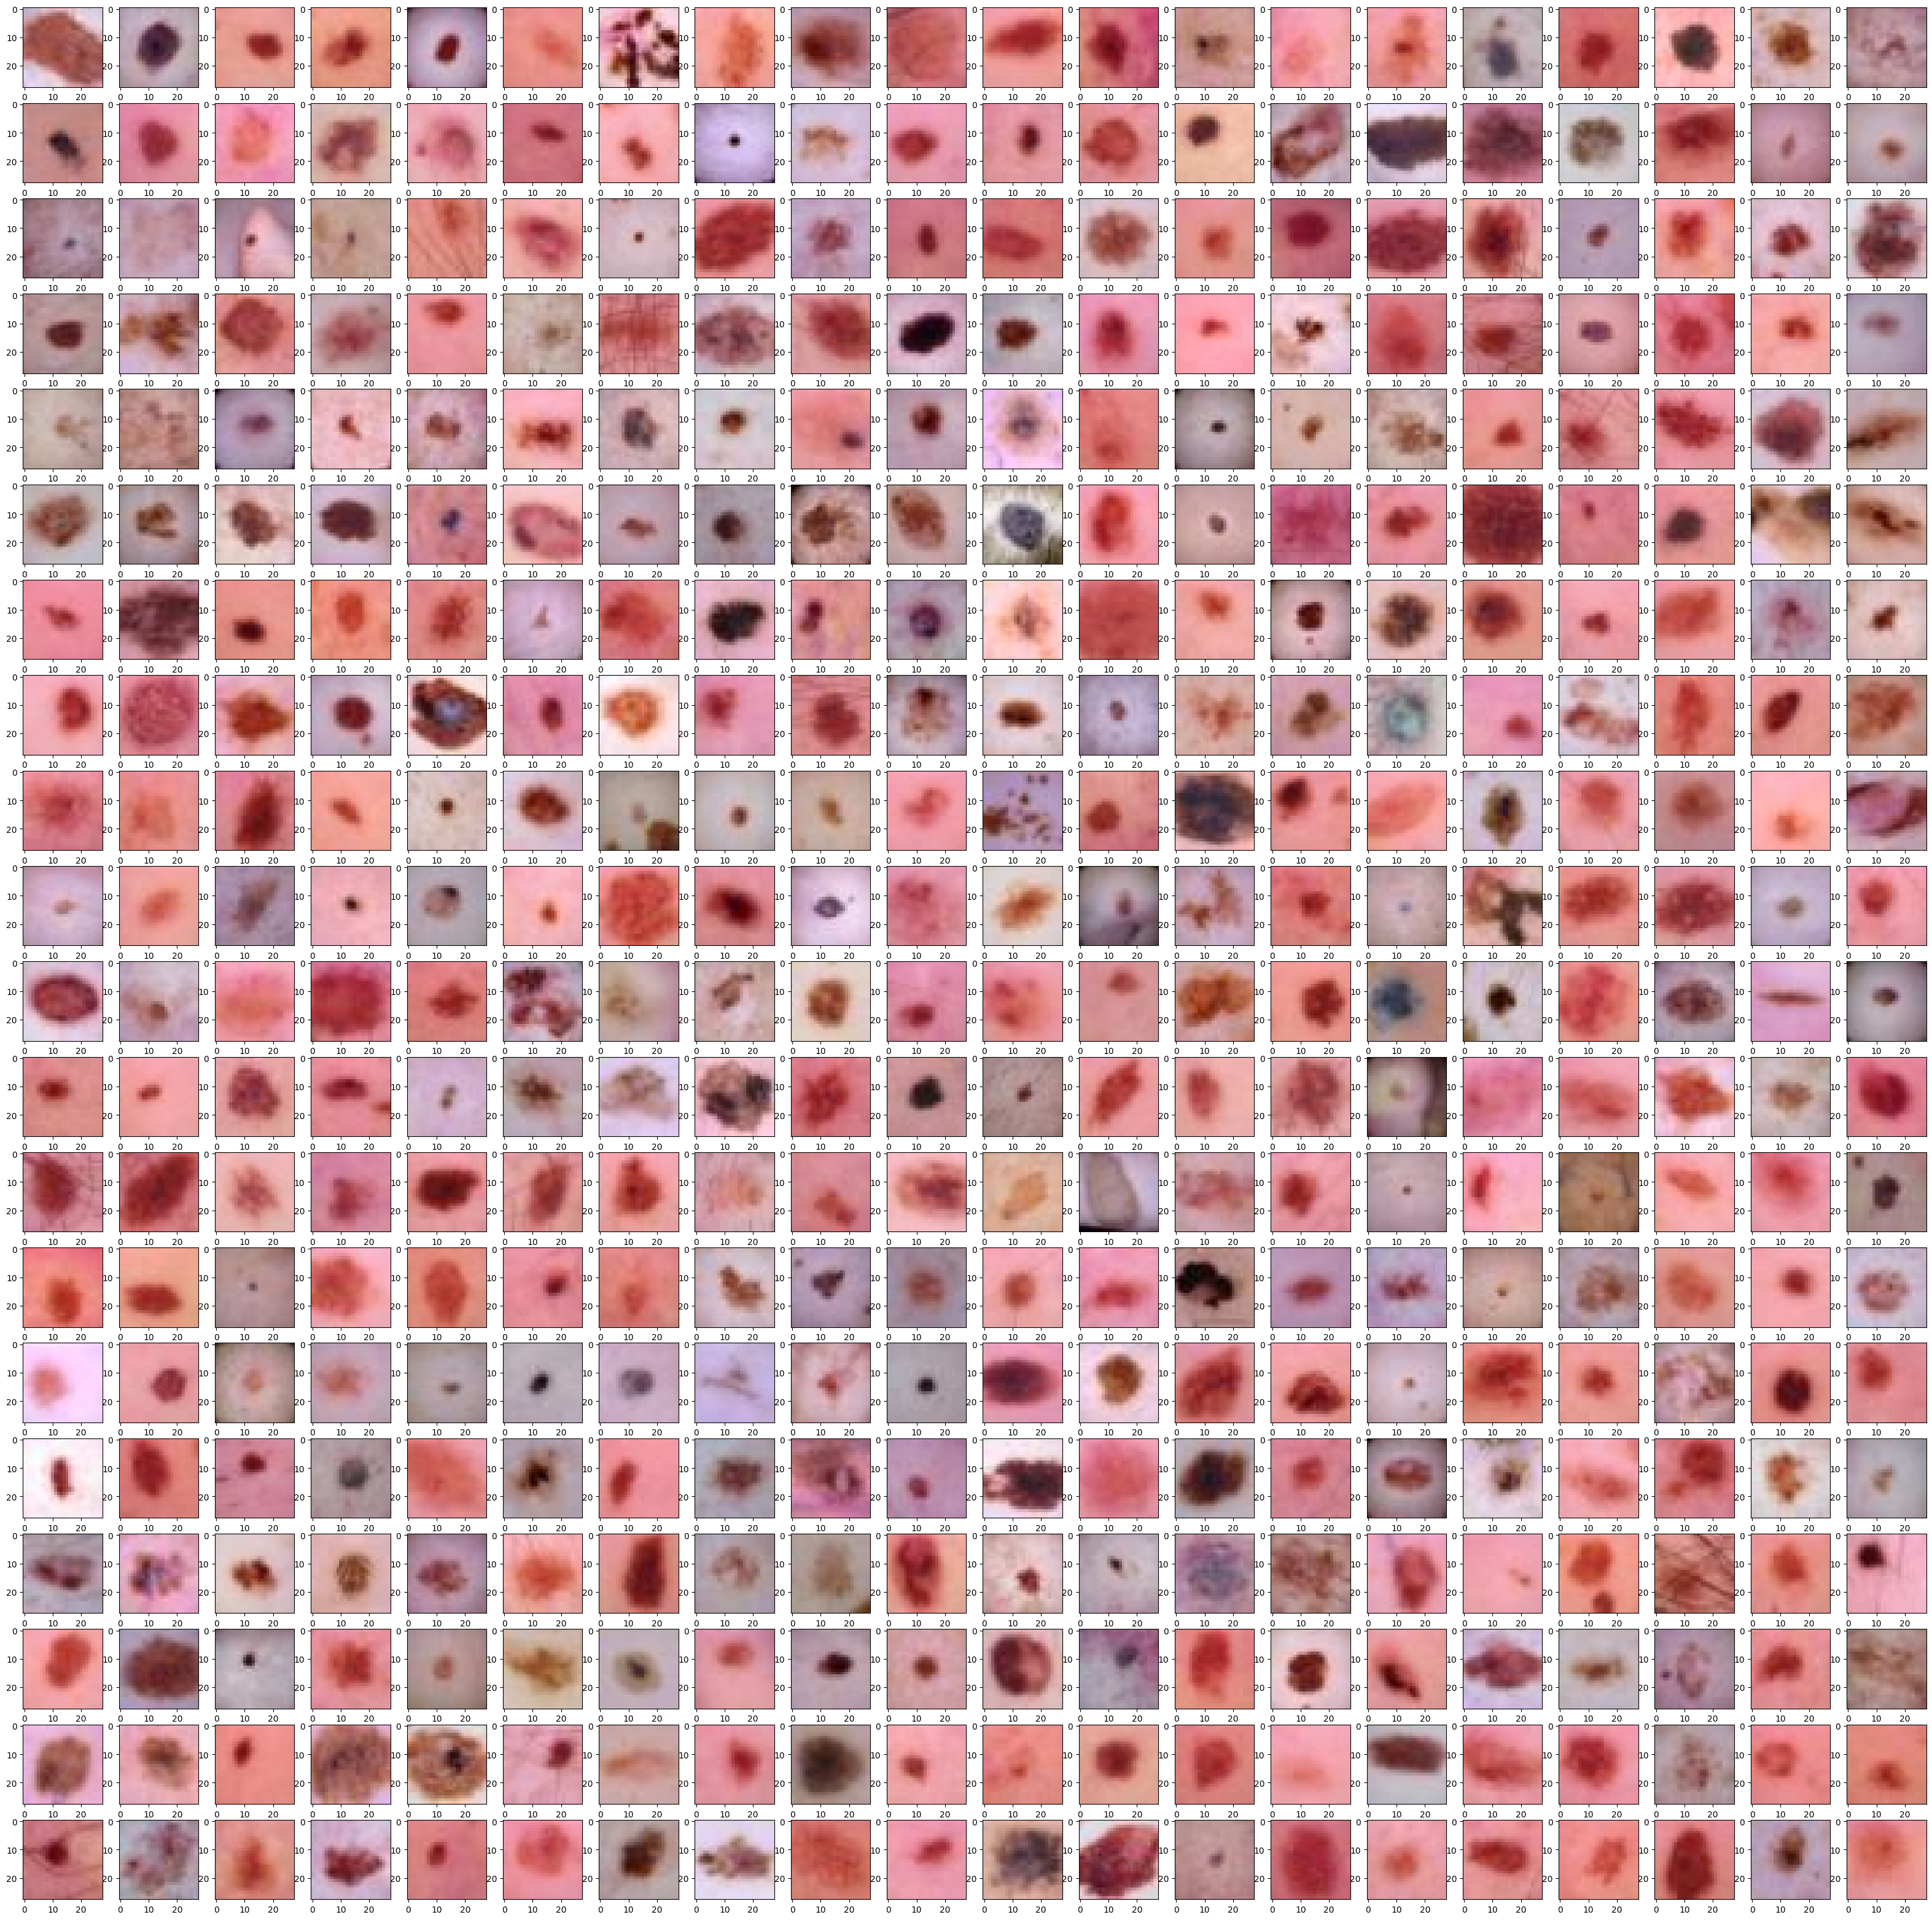

In [36]:
novo = np.reshape(X_test,(X_test.shape[0],28,28,3))
#print(novo)
from PIL import Image
fig = plt.figure(figsize=(40, 40))
#img = Image.fromarray(novo[0], 'RGB')
#img.show()

columns = 20
rows = 20
for i in range(1,columns*rows+1):
    img = Image.fromarray(novo[i], 'RGB')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()